In [1]:
from lib.utils import crop_image_label
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import json
from glob import glob
from tqdm import tqdm

# View cropped images with labels

In [2]:
files = iter(glob('./img/95-5-10-1/images/*.jpg'))

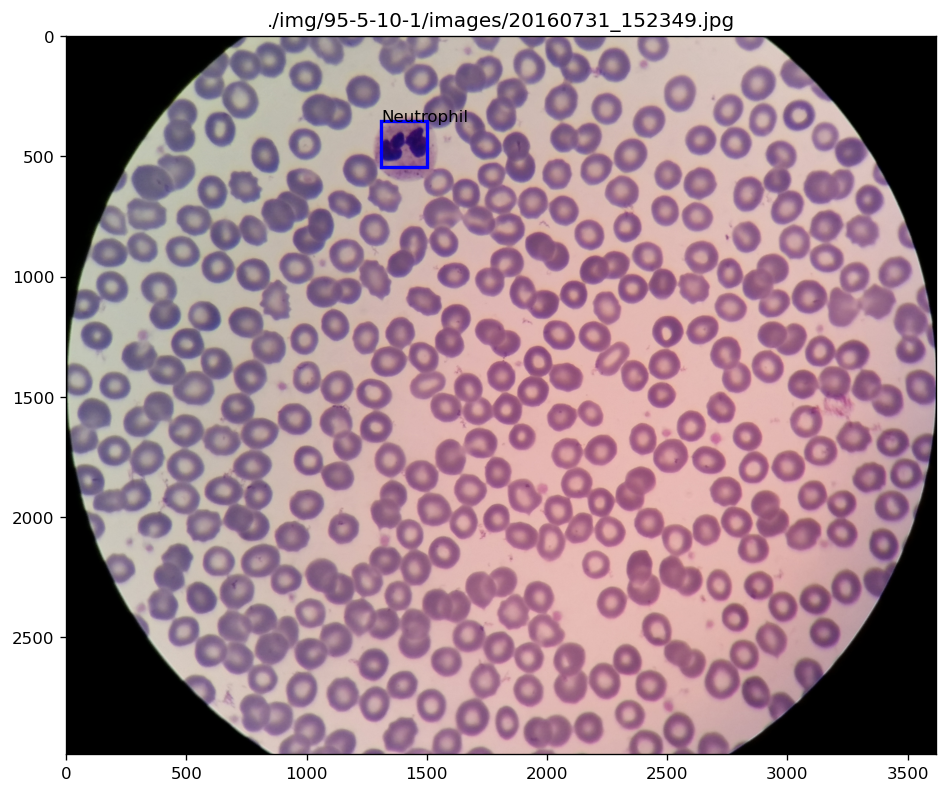

In [3]:
file = next(files)

fig, ax = plt.subplots(figsize=(8, 8), dpi=120)

im, labels = crop_image_label(file, file.replace('images', 'jsons').replace('jpg', 'json'), 100)
X, Y, C = im.shape

ax.imshow(im)
ax.set_title(file)
for label in labels:
    rect = patches.Rectangle((label[1], label[2]), label[3], label[4], linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(label[1], label[2], label[0])

plt.tight_layout()

# Get object classes from json files

In [4]:
classes = []
for file in tqdm(glob('./img/95-5-10-1/jsons/*.json')):
    with open(file, 'rt') as f:
        labels = json.load(f)

    stop = False
    i = 0
    labelsList = []

    while (not stop):
        try:
            label = labels[f'Cell_{i}']

            l1, l2 = label['Label1'], label['Label2'] 
            # l =  l1 + ' | ' + l2 if l1 != l2 else l1

            classes.append(l1)
            classes.append(l2)
            i += 1
        except KeyError as e:
            stop = True

classes = [c for c in list(set(classes)) if c is not None]

for i, imgClass in enumerate(classes):
    print('{:3d} : {:s}'.format(i, imgClass))

  0%|          | 0/978 [00:00<?, ?it/s]

100%|██████████| 978/978 [00:00<00:00, 1028.86it/s]

  0 : Large Lymph
  1 : Monocyte
  2 : Eosinophil
  3 : Small Lymph
  4 : Burst
  5 : Band
  6 : Neutrophil
  7 : Not centered
  8 : Unknn
  9 : Artifact


# Crop images and adjust boxes and labels to Yolo format

In [6]:
for file in tqdm(glob('./img/95-5-10-1/images/*.jpg')):
    im, labels = crop_image_label(file, file.replace('images', 'jsons').replace('jpg', 'json'), 100)
    X, Y, C = im.shape
    # print(X, Y)
    mpimg.imsave('./img/yolo_data/{}'.format(file.split('/')[-1]), im)

    with open('./img/yolo_data/{}.txt'.format(file.split('/')[-1].split('.')[0]), 'wt') as f:
        for label in labels:
            # rect = patches.Rectangle((label[1], label[2]), label[3], label[4], linewidth=2, edgecolor='b', facecolor='none')
            l, x, y, dx, dy = label[0].split('|')[0].strip(), label[1] / X, label[2] / Y, label[3] / X, label[4] / Y
            x0, y0 = x + dx / 2, y + dy / 2
            f.write('{:3d}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n'.format(classes.index(l), y0, x0, dy, dx))
            # ax.text(label[1], label[2], label[0])

# plt.tight_layout()

  0%|          | 0/978 [00:00<?, ?it/s]

 52%|█████▏    | 506/978 [26:34<24:46,  3.15s/it] 


TypeError: can only concatenate str (not "NoneType") to str

# Check final result

In [33]:
cropped_files = glob('./img/yolo_data/*.jpg')
cropped_files.sort()
cropped_files = iter(cropped_files)

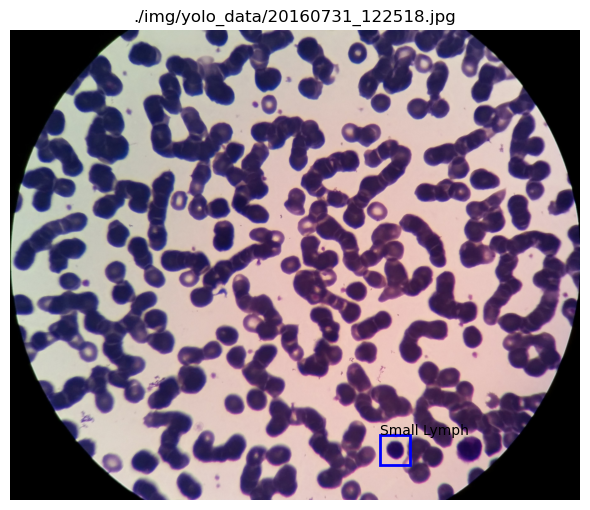

In [54]:
file = next(cropped_files)

fig, ax = plt.subplots(figsize=(6, 6), dpi=100)

im = mpimg.imread(file)
with open(file.replace('jpg', 'txt'), 'rt') as f:
    labels = f.readlines()

X, Y, C = im.shape

ax.imshow(im)
ax.set_title(file)
for label in labels:
    label = label.split()
    box_class_idx = int(label[0])
    box_class = classes[box_class_idx]
    label_x, label_y = float(label[1]), float(label[2])
    label_dx, label_dy = float(label[3]), float(label[4])
    y, x, dy, dx = int(Y * label_x), int(X * label_y), int(Y * label_dx), int(X * label_dy)

    x, y = x - dx // 2, y - dy // 2

    rect = patches.Rectangle((x, y), dx, dy, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, box_class)

plt.axis('off')

plt.tight_layout()